# <center>  Deep Neural Network (DNN) using plain TensorFlow

## <font color = 'blue'> Get the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from time import time

%store -r
%store

Stored variables and their in-db values:
X_16_val                  -> array([[-0.05248989,  0.95262376, -0.95081096, ...
X_32_val                  -> array([[-0.26412427,  0.80742202,  0.90784197, ...
X_32test_std              -> defaultdict(<class 'list'>, {0: array([[-0.2641242
X_32train_std             -> array([[-0.71199092,  0.15545522, -0.78672279, ...
X_test                    -> defaultdict(<class 'list'>, {0: array([[[ 0.003087
X_test_std                -> defaultdict(<class 'list'>, {0: array([[ -5.248988
X_train                   -> array([[[ -8.82267195e-04,   4.11425252e-03,  -7.3
X_train_std               -> array([[-0.71199092,  0.15545522, -0.78672279, ...
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_16_val                  -> array([7, 6, 5, ..., 1, 4, 7])
y_32_test                 -> defaultdict(<class 'list'>, {0: array([4, 6, 6, ..
y_32_train                -> array([4, 2, 0, ..., 1, 4, 6])
y_32_val                  -> array([4, 

In [2]:
print("Training data: ", X_32train_std.shape, "and labels: ", y_32_train.shape)
print(" ")
print("Test data:")
print("Total", len(X_32test_std), X_32test_std[18].shape, "arrays for SNR values:")
print(sorted(X_32test_std.keys()))

Training data:  (80000, 32) and labels:  (80000,)
 
Test data:
Total 20 (4000, 32) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [3]:
# tf.reset_default_graph()

## <font color = 'blue'> Design and train the DNN

In [4]:
# ----------------- Initialize parameters -----------------------


n_hidden1 = 256
n_hidden2 = 256
n_outputs = 8

X = tf.placeholder(tf.float32, shape=(None, 32))

y = tf.placeholder(tf.int64, shape=(None))

# ------------------- Define layers -----------------------

from tensorflow.contrib.layers import fully_connected

def layer(X, n_neurons, activation):
    layer = fully_connected(X, n_neurons, activation_fn = activation, 
                            weights_initializer = tf.contrib.layers.xavier_initializer())
    dropout_layer = tf.layers.dropout(layer, rate = 0.4, training = True)
    return dropout_layer

layer1 = layer(X, n_hidden1, activation = tf.nn.relu)

layer2 = layer(layer1, n_hidden2, activation = tf.nn.relu)

logits = fully_connected(layer2, n_outputs, activation_fn = None, weights_initializer = tf.contrib.layers.xavier_initializer())

# ----------------- Specify performance measure ----------------------

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
# ------------------ Execution phase ----------------------------------    

n_epochs = 1000
batch_size = 1024
n_train = X_train_std.shape[0]
n_iter = n_train//batch_size

saver = tf.train.Saver()

min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

acc_test = defaultdict(list)

start = time()
path = "./DNNdropout3.ckpt"

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_iter):
            rand_indices = np.random.choice(n_train,batch_size) #select random samples to form mini batches   
            X_batch, y_batch = X_32train_std[rand_indices], y_32_train[rand_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        valid_loss, acc_val = sess.run([loss, accuracy], feed_dict={X: X_32_val, y: y_32_val})
        
        # Early stopping 
        
        if valid_loss < min_loss:
            save_path = saver.save(sess, path)
            min_loss = valid_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement > max_epochs_without_improvement:
                print("** EARLY STOPPING ** ")
                break
        print("{}\tValidation loss: {:.6f}\tMinimum loss: {:.6f}\tAccuracy on validation set: {:.2f}".format(
            epoch, valid_loss, min_loss, acc_val))

print(" ")
with tf.Session() as sess:
    saver.restore(sess, path)
    for snr in snrs:
        acc_test[snr] = accuracy.eval(feed_dict={X: X_32test_std[snr], y: y_32_test[snr]})

print("Training and testing took %f minutes"%(float(time() - start)/60))

0	Validation loss: 1.786012	Minimum loss: 1.786012	Accuracy on validation set: 0.35
1	Validation loss: 1.704666	Minimum loss: 1.704666	Accuracy on validation set: 0.39
2	Validation loss: 1.655772	Minimum loss: 1.655772	Accuracy on validation set: 0.41
3	Validation loss: 1.627828	Minimum loss: 1.627828	Accuracy on validation set: 0.42
4	Validation loss: 1.600820	Minimum loss: 1.600820	Accuracy on validation set: 0.43
5	Validation loss: 1.590511	Minimum loss: 1.590511	Accuracy on validation set: 0.44
6	Validation loss: 1.579173	Minimum loss: 1.579173	Accuracy on validation set: 0.45
7	Validation loss: 1.571726	Minimum loss: 1.571726	Accuracy on validation set: 0.45
8	Validation loss: 1.562692	Minimum loss: 1.562692	Accuracy on validation set: 0.46
9	Validation loss: 1.559751	Minimum loss: 1.559751	Accuracy on validation set: 0.46
10	Validation loss: 1.552105	Minimum loss: 1.552105	Accuracy on validation set: 0.46
11	Validation loss: 1.547368	Minimum loss: 1.547368	Accuracy on validation 

## <font color = 'blue'> Test the DNN

In [5]:
for snr in snrs:
    print("DNN's test accuracy on %d dB SNR samples = "%(snr), acc_test[snr])   

DNN's test accuracy on -20 dB SNR samples =  0.136
DNN's test accuracy on -18 dB SNR samples =  0.1425
DNN's test accuracy on -16 dB SNR samples =  0.13525
DNN's test accuracy on -14 dB SNR samples =  0.14
DNN's test accuracy on -12 dB SNR samples =  0.1575
DNN's test accuracy on -10 dB SNR samples =  0.1935
DNN's test accuracy on -8 dB SNR samples =  0.27925
DNN's test accuracy on -6 dB SNR samples =  0.357
DNN's test accuracy on -4 dB SNR samples =  0.417
DNN's test accuracy on -2 dB SNR samples =  0.476
DNN's test accuracy on 0 dB SNR samples =  0.57425
DNN's test accuracy on 2 dB SNR samples =  0.69425
DNN's test accuracy on 4 dB SNR samples =  0.7965
DNN's test accuracy on 6 dB SNR samples =  0.839
DNN's test accuracy on 8 dB SNR samples =  0.83275
DNN's test accuracy on 10 dB SNR samples =  0.8435
DNN's test accuracy on 12 dB SNR samples =  0.837
DNN's test accuracy on 14 dB SNR samples =  0.83125
DNN's test accuracy on 16 dB SNR samples =  0.83325
DNN's test accuracy on 18 dB SN

## <font color = 'blue'> Visualize DNN's performance

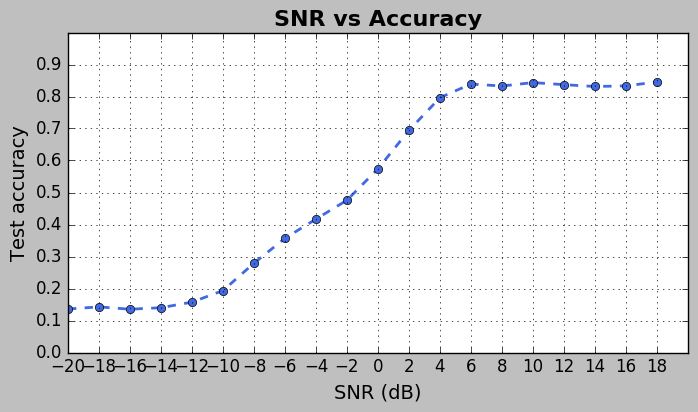

In [2]:
import matplotlib.pyplot as plt

plt.style.use('classic')

fig = plt.figure(figsize=(8, 4), dpi=100)
x = snrs
y = list(acc_test.values())
plt.plot(x, y, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('SNR vs Accuracy', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()